<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Convolutional Neural Network with Batch-Normalization </h1> 

<h2>Table of Contents</h2>
<b>This lab takes a long time to run so the results are given. You can run the notebook your self but it may take a long time.</b>
<p>In this lab, we will compare a Convolutional Neural Network using Batch Normalization with a regular Convolutional Neural Network  to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process. </p>

<ul>
    <li><a href="#read_me">Read me Batch Norm for Convolution Operation  </a></li>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Two Types of Convolutional Neural Network</a></li>
<li><a href="#Train">Define Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>

### Batch Norm for Convolution Operation

Like a fully connected network, we create a *BatchNorm2d* object, but we apply it to the 2D convolution object.  
First, we create objects *Conv2d* object; we require the number of output channels, specified by the variable *OUT*.  

<code>self.cnn1 = nn.Conv2d(in_channels=1, out_channels=OUT, kernel_size=5, padding=2) </code>

We then create a Batch Norm  object for 2D convolution as follows:

<code>self.conv1_bn = nn.BatchNorm2d(OUT)</code>

The parameter out is the number of channels in the output. We can then apply batch norm  after  the convolution operation :

<code>
x = self.cnn1(x)
x = self.conv1_bn(x)
</code>

<!--Empty Space for separating topics-->

<h2>Preparation</h2>

In [1]:
# Import the libraries we need to use in this lab
import time
START_TIME = time.time()

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
print(torch.cuda.is_available())
DEV = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEV)

True
cuda:0


In [3]:
def show_data(data_sample, img_sz):
    plt.imshow(data_sample[0].cpu().numpy().reshape(img_sz, img_sz), cmap='gray') # <--- 
    plt.title('y = '+ str(data_sample[1]))
    plt.show()

<h2 id="Makeup_Data">Get the Data</h2> 

We create a transform to resize the image and convert it to a tensor :

In [4]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.

In [5]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, 
                            transform=composed)

Load the validation dataset by setting the parameters train  <code>False</code>.

In [6]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, 
                                 transform=composed)

We can see the data type is long.

In [7]:
train_dataset[0][1]

5

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">

Print out the fourth label 

In [8]:
## The label for the fourth data element
train_dataset[3][1]

1

Plot the fourth sample 

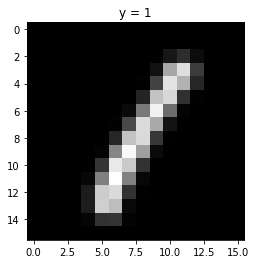

In [9]:
## The image for the fourth data element
show_data(train_dataset[3], img_sz=IMAGE_SIZE)

The fourth sample is a "1".

<h2 id="CNN">Build a Two Convolutional Neural Network Class</h2>

Build a Convolutional Network class with:  
- 2 Convolutional layers and 
- 1 fully connected layer. 

Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [10]:
class CNN(nn.Module):
    ## Contructor
    def __init__(self, out_1=16, out_2=32, num_of_classes=10):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        #
        self.fc1 = nn.Linear(out_2*4*4, num_of_classes) # 256, 10 outputs
    
    ## Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        #
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        # 
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Build a Convolutional Network class with two Convolutional layers and one fully connected layer. But we add Batch Norm for the convolutional layers. 

In [11]:
class CNNBatchNorm(nn.Module):
    ## Contructor
    def __init__(self, out_1=16, out_2=32, num_of_classes=10):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        #
        self.fc1 = nn.Linear(out_2*4*4, num_of_classes) # 256, 10 outputs
        self.bn_fc1 = nn.BatchNorm1d(num_of_classes)
    
    ## Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        #
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        # 
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

Function to train the model 

In [12]:
def train_model(model, train_loader, validation_loader, optimizer, 
                n_epochs=10, n_test=len(validation_dataset)):
    cost_list, acc_list = [], []
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()                        # <-------
            optimizer.zero_grad()
            x, y = x.to(DEV), y.to(DEV)
            
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost_list.append(loss.data)

        correct = 0
        ## Perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()                        # <-------
            x_test, y_test = x_test.to(DEV), y_test.to(DEV)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        acc = correct / n_test
        acc_list.append(acc)
    #
    return cost_list, acc_list

### Define the Convolutional Neural Network Classifier
    
Model, criterion function, optimizer and train the Model.
There are 16 output channels for the first layer, and 32 output channels for the second layer 

In [13]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=5000)

In [14]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)
model.to(DEV)
model

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

Define the loss function, the optimizer and the dataset loader 

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)


Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**

In [16]:
# Train the model
start = time.time()

loss_list_def, acc_list_def = train_model(model=model, train_loader=train_loader,
                                          validation_loader=validation_loader,
                                          optimizer=optimizer,
                                          n_epochs=10)
print("elapsed time (s): ", time.time() - start)

# cpu: 168.6865s
# gpu:  56.5624s

elapsed time (s):  56.56248903274536


Repeat the Process for the model with **batch norm** 

In [17]:
model_bn = CNNBatchNorm(out_1=16, out_2=32)
model_bn.to(DEV)
model_bn

CNNBatchNorm(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
  (bn_fc1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [18]:
optimizer = torch.optim.SGD(model_bn.parameters(), lr = learning_rate)

In [19]:
start = time.time()

loss_list_bn, acc_list_bn = train_model(model=model_bn, 
                                        train_loader=train_loader,
                                        validation_loader=validation_loader,
                                        optimizer=optimizer,
                                        n_epochs=10)
print("elapsed time (s): ", time.time() - start)

# cpu: 194.1153s
# gpu:  58.4796s

elapsed time (s):  58.479687213897705


<h2 id="Result">Analyze Results</h2> 

Plot the loss with both networks.

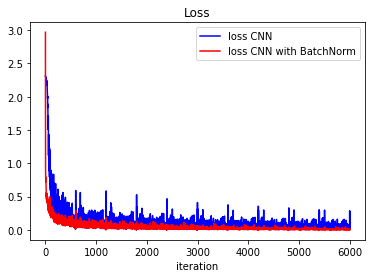

In [20]:
# Plot the loss and accuracy
plt.plot(loss_list_def, 'b', label='loss CNN')
plt.plot(loss_list_bn, 'r', label='loss CNN with BatchNorm')
plt.xlabel('iteration')
plt.title("Loss")
plt.legend()

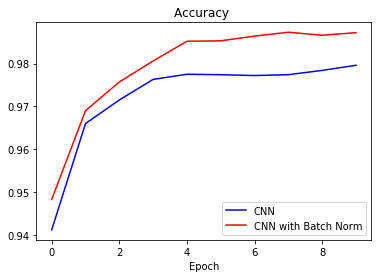

In [21]:
plt.plot(acc_list_def, 'b', label='CNN')
plt.plot(acc_list_bn, 'r', label='CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()

We can see the CNN with batch norm performers better, with faster convergence.

In [22]:
## Done
print("elapsed time (s): ", time.time() - START_TIME)  
# gpu:  117.83055543899536 - 10 epochs
# cpu:  363.83137702941895 - 10 epochs

elapsed time (s):  117.83055543899536


<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

Thanks to Magnus <a href="http://www.hvass-labs.org/">Erik Hvass Pedersen</a> whose tutorials helped me understand convolutional Neural Network

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.